In [1]:
# Importing libraries
import numpy as np
from numpy import random

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import cm
from matplotlib.pyplot import figure

from functools import partial 

import scipy 
from scipy.optimize import fmin
from scipy.optimize import minimize
from scipy.spatial import Delaunay

from scipy.stats import norm

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

In [2]:
def phi_approx(pi, coeffs):
    """function which calculates the approximate value of the dynamic system's output given tuning parameters k
        and cost coefficients.
        pi has to be a nx3 array or 1x3 array; cost_coeffs1 a 3x1 array; cost_coeffs2 a 3x3 array"""
    
    if len(pi.shape)>1: #For the case when phi_approx is evaluated for an array of pi values vs when phi_approx is evaluated for a single pi vector i.e. 1x3 array
        phi_approx = np.matmul(pi, coeffs[0:3])
        phi_approx += coeffs[3]*np.dot(pi[:,0].T,pi[:,0].T) # coeffs is a 1D array with 6 values 
        phi_approx += coeffs[4]*np.dot(pi[:,1].T,pi[:,1].T)
        phi_approx += coeffs[5]*np.dot(pi[:,2].T,pi[:,2].T)
    else:
        phi_approx = np.matmul(pi, coeffs[0:3])
        phi_approx += coeffs[3]*(pi[0]**2)
        phi_approx += coeffs[4]*(pi[1]**2)
        phi_approx += coeffs[5]*(pi[2]**2)
    
    return phi_approx

In [3]:
# # Defining Jacobian of known approximation function - not being used anymore 
# def quadratic_jacobian(pi, coeffs):
#     """Returns the Jacobian of the approximate function phi_approx"""
#     return (
#         (coeffs[0] + (2*pi[0]*coeffs[3])),
#         (coeffs[1] + (2*pi[1]*coeffs[4])),
#         (coeffs[2] + (2*pi[2]*coeffs[5]))
#     )


In [4]:
def sys_model(x, t, u):
    """Function modelling the dynamic behaviour of the system in question with a control term u. 
        Returns the state of the ODE at a given point in time"""
    dxdt = 2*x + u
    return dxdt

In [5]:
def integrator_function(pi, x0 , N, T, xref):
    """Function which takes input pi - 1x3 array of k values- and integrates the system equation to return a system response.
    This function is called as many times as there are k triplets in the phi function input.
    """
    Dt = T/N
    
    k_vals = pi #pi can only have a single triplet of k's. 
    error = []
    U = []
    time = [0]
    x = [x0]
    
    for k in range(0, N): 
        #Determine the error and store it's value
        e = xref[k] - x[k]
        error.append(e)
        rv = np.random.normal(loc=0, scale=0.2, size=1) # Generate a random variable to create disturbance in the surroundings
        
        #Determine the controller response u_k and store its value
        if k == 0:
            u = k_vals[0]*e + k_vals[1]*sum(error) + rv # Controller equations 
        else:
            u = k_vals[0]*e + k_vals[1]*sum(error) + (e - error[k-1])*k_vals[2] + rv # Controller equations 
            
        U.append(u) # list of control outputs for a provided k_vals

        if k < N:
            #Determine the new x value and store it
            t = time[k] + Dt

            x_new = scipy.integrate.solve_ivp(sys_model,
                              t_span = (time[k],t),
                              y0 = [x[-1]], 
                              args = (u,))

            x.append(x_new["y"][-1][-1])
            time.append(t)
        
    #Calculate phi
    error = np.array(error) #calc error
    phi = np.sum(error**2) # Phi function 
    
    return phi, x, U
    

In [27]:
test =  integrator_function(pi = np.array([1,1,1]), x0=5, xref =xref, N=10, T=10)
test

(27692649.051105432,
 [5,
  25.849331600654747,
  -3.5084363608173845,
  66.98109683588929,
  -82.73465107007011,
  237.26847096615867,
  -452.4410541429018,
  1026.231921098656,
  -2151.319871463013,
  4672.93929634301,
  -9984.674100786973],
 [array([19.8493316]),
  array([-32.35776796]),
  array([65.4895332]),
  array([-156.71574791]),
  array([311.00312204]),
  array([-700.70952511]),
  array([1465.67297524]),
  array([-3192.55179256]),
  array([6807.25916781]),
  array([-14676.61339713])])

In [6]:
N = 200 # Number of samples in the time domain
T = 3 # Duration of the controller test in seconds; DO IT FOR 1S ONLY FOR NON LINEAR SYSTEMS
Dt = T/N # Size of the time steps 
time = [Dt*x for x in range(0,N)]

trajectory_1 = 15*np.ones(int(len(time)/4), dtype=int)
trajectory_2 = 20*np.ones(int(len(time)/4), dtype=int)
trajectory_3 = 18*np.ones(int(len(time)/4), dtype=int)
trajectory_4 = 10*np.ones(int(len(time)/4), dtype=int)

xref = np.concatenate((trajectory_1,trajectory_2,trajectory_3,trajectory_4))

In [7]:
def phi(pi, xref=xref, x0 = 5 , N=200, T=3, return_system_response = False): #= 15
    """This function takes an array of k values stored in an nd array pi and returns the value of phi associated
        with each of the triplets of k within pi."""
    Dt = T/N
    phi_solutions = []
    
    control_outputs = [] # list of controller outputs 

    for idx in range(pi.shape[0]):
        phi, system_response, control_out = integrator_function(pi[idx], x0, N, T, xref=xref)
        phi_solutions.append(phi) 
        control_outputs.append(control_out) #append to the list of controller outputs 
        
        # Adding disturbance to the integrator output.
        system_response = system_response + np.random.normal(loc=0, scale=0.1, size=len(system_response)) 
        
    # Calculate the phi value based on the integration of the dynamic equation. 
    if pi.shape[0] != 1:
        pi_opt = pi[np.array(phi_solutions).argmin()]
        print("Pi of best Phi Actual: ", pi_opt)
        phi_test, x_opt, control = integrator_function(pi_opt, x0, N, T, xref=xref)
        time = [Dt*x for x in range(0, N)]
        
        # Plot the graph of the system response for a specific set of k values over time FOR EACH ITERATION i.e. as many triplets of k as there are in pi. 
# Original version is below
#         sns.set()

#         fig, ax = plt.subplots(figsize = (10,10))
#         fig.set_size_inches(18.5/2, 10.5/2)
#         plt.title("System Reponse over time")
#         plt.xlabel("time")
#         plt.ylabel('response')
#         plt.plot(time, x_opt)

#         plt.show()

# This version below plots the responses on the same axis.         
#         fig, ax = plt.subplots()
#         fig.set_size_inches(18.5/2, 10.5/2)
#         plt.title("System Reponse over time")
#         plt.xlabel("time")
#         plt.ylabel('response')
#         fig = plt.plot(time, x_opt, 'b', label='pi opt for phi actual')



    if return_system_response:
        return phi_solutions, system_response, control_outputs
    else:
        return phi_solutions 

In [8]:
### Lazy loading ensures that once phi is calculated it is not recalculated with each evaluation of the outer objective function 
### because the phi(pi) stays the same but phi_approx changes and needs to be optimised

def outer_objective_function(approx_coeffs, pi, lazy_loading, xref = xref, x0 = 5, global_phi_store=None):  # = 15
    load_store = 0    # Initialise a variable for the lazy loading work-around
    
    if not (pi == lazy_loading["pi"]).all():
        lazy_loading["pi"] = pi
        lazy_loading["phi(pi)"] = phi(pi, xref, x0)
        
        if global_phi_store is not None:
#             print("global saving")
            temp_df = pd.DataFrame.from_dict(data={"kp": lazy_loading["pi"][:,0], 
                                                   "ki": lazy_loading["pi"][:,1], 
                                                   "kd": lazy_loading["pi"][:,2], 
                                                   "phi(pi)": lazy_loading["phi(pi)"]
                                                  }
                                            )
    
            global_phi_store[0] = global_phi_store[0].append(temp_df, ignore_index=True)
    else:
#         print("lazy Loading")
        load_store += 1 # This makes it a bit less cluttered
    
    
    phi_approx_eval = phi_approx(pi, coeffs=approx_coeffs)
    
    sse = np.sum((lazy_loading["phi(pi)"] - phi_approx_eval)**2)/len(phi_approx_eval) # Sum of square errors := sse; had to normalise the value to the length of the number of phi_approx values calculated. 
    return sse

In [9]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [10]:
print(xref)
var = [10, 20, 30, 40]
error_list = []
xref.size
# for k in range(0,4):
#     e = xref[k] - var[k]
#     error_list.append(e)
#     print(error_list)


[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10]


200

Pi Lower Bound:  [0, 0, 0]
Pi Upper Bound:  [8 8 8]
Pi of best Phi Actual:  [8. 8. 8.]
Optimal coeffs:  [1. 1. 1. 1. 1. 1.]
Optimization terminated successfully.
         Current function value: 0.000169
         Iterations: 1
         Function evaluations: 85
Pi Opt for Phi Approx:  [5.62867359e-05 5.62867359e-05 5.62867359e-05]


[ True  True  True]
Pi Lower Bound:  [0, 0, 0]
Pi Upper Bound:  [3.6, 3.6, 3.6]
Pi of best Phi Actual:  [3.6  2.16 2.16]
Optimal coeffs:  [-3399.24510447  -758.98507325  -169.3131316      4.43055805
     4.43055805     4.43055805]
Optimization terminated successfully.
         Current function value: -153761.110286
         Iterations: 2
         Function evaluations: 159
Pi Opt for Phi Approx:  [39.99741192 39.99999991 19.10745415]


[False False False]
Pi Lower Bound:  [36.75741191975513, 36.759999911473315, 15.867454154452998]
Pi Upper Bound:  [43.23741191975513, 43.23999991147332, 22.347454154452997]
Pi of best Phi Actual:  [43.23741192 36.75999991 15.86

<Figure size 1152x648 with 0 Axes>

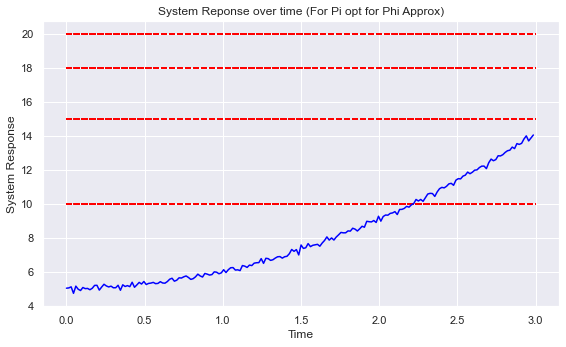

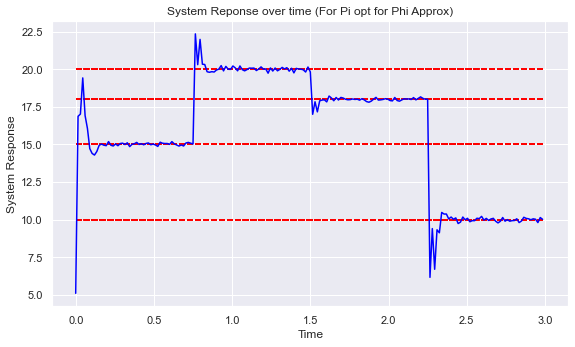

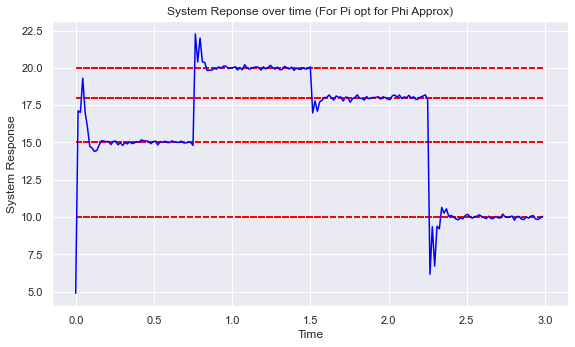

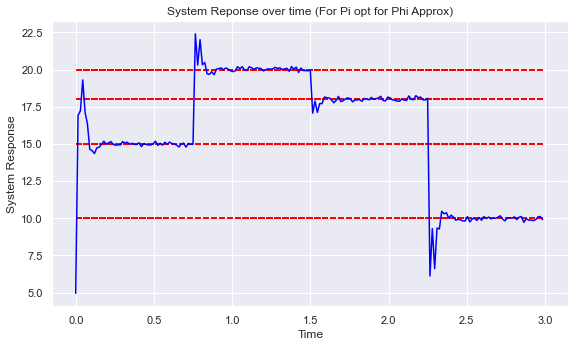

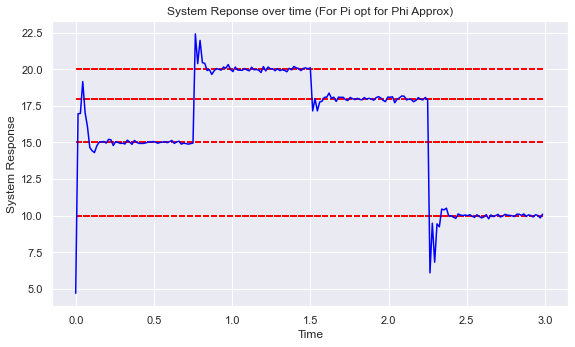

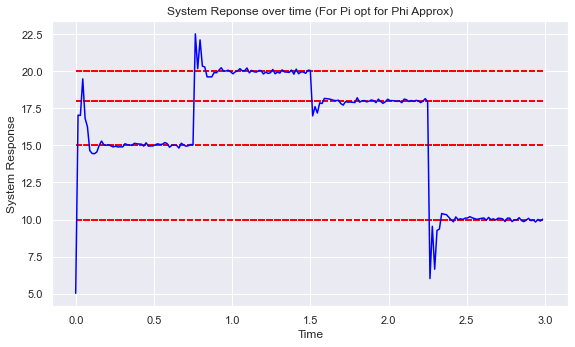

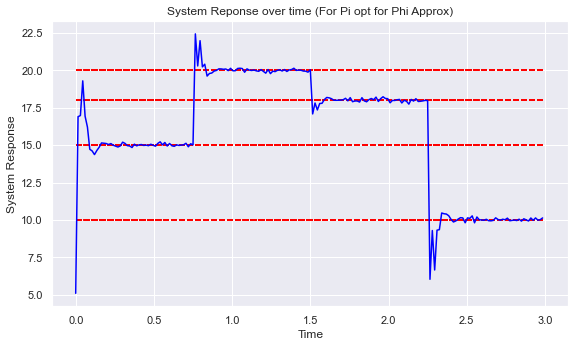

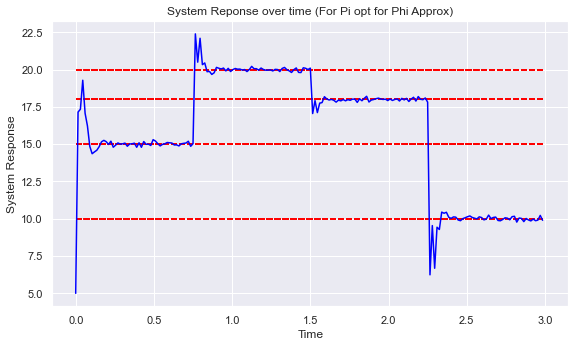

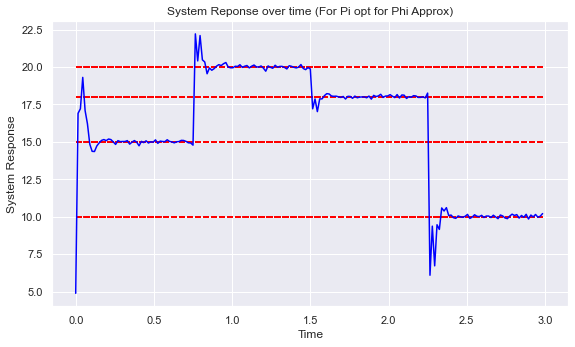

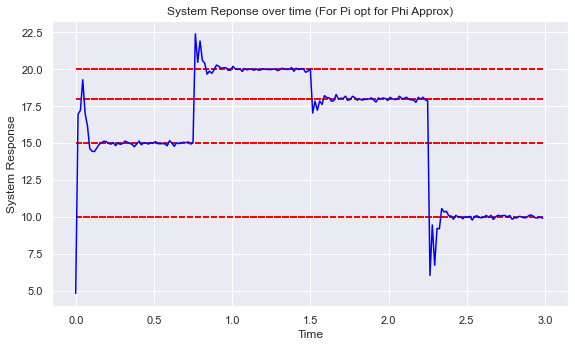

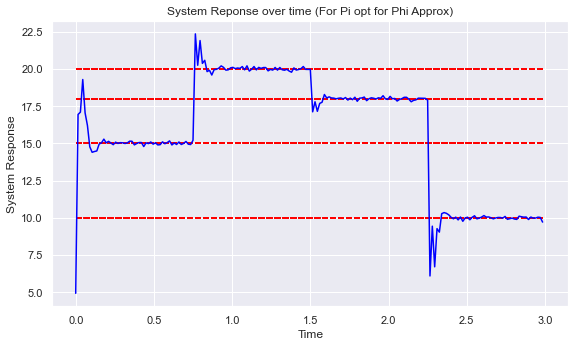

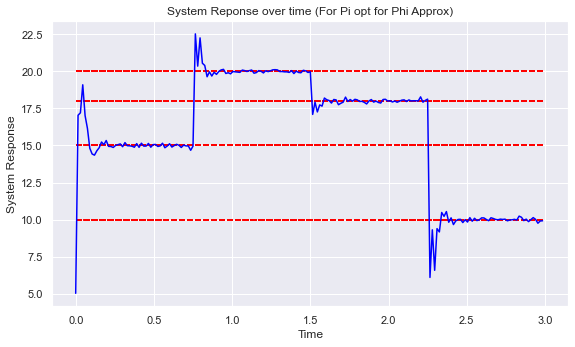

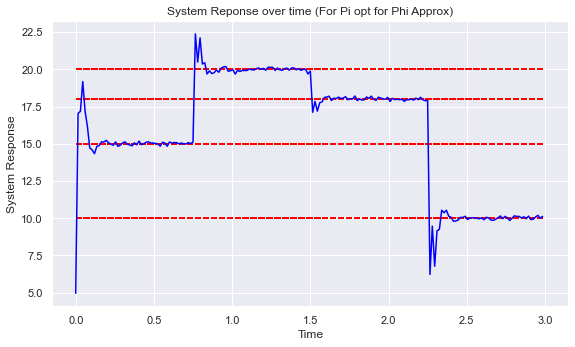

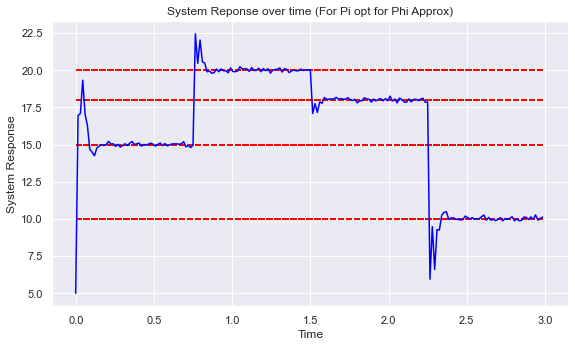

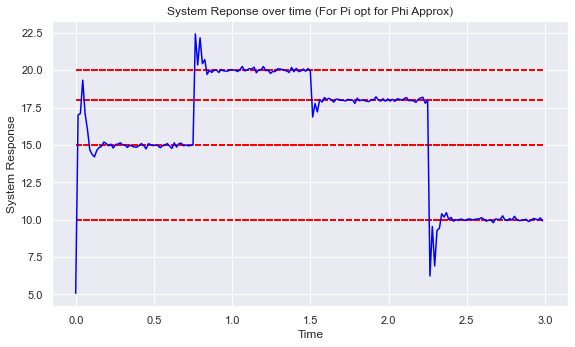

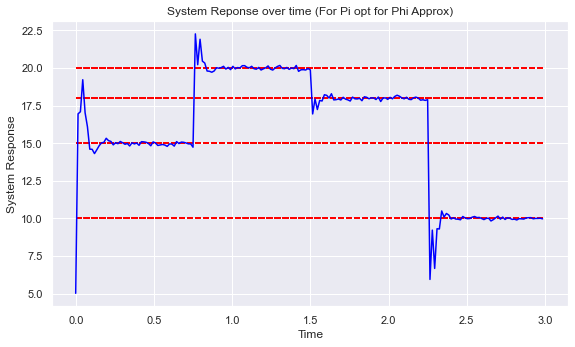

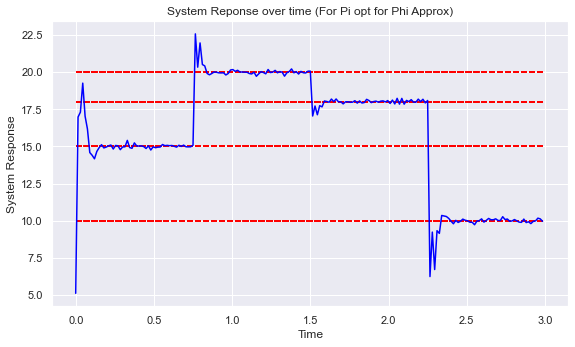

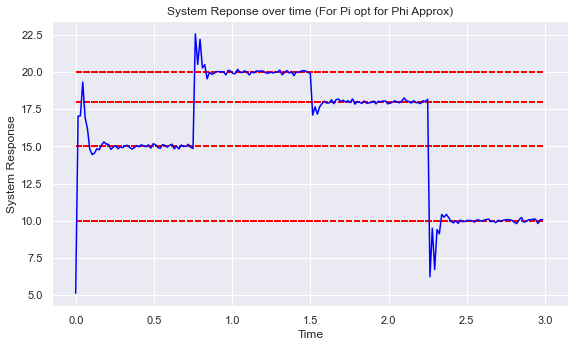

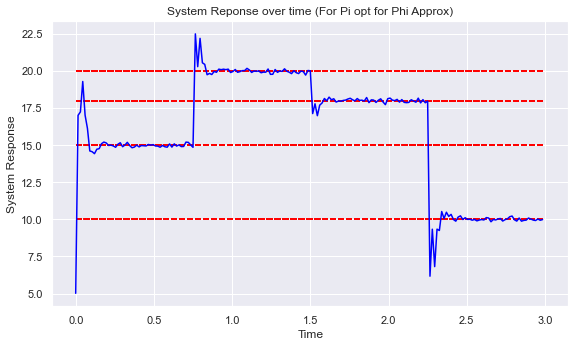

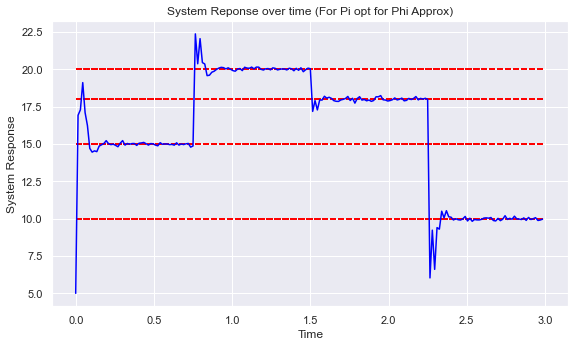

In [15]:
#Initialise the guess for the optimal values of the quadratic coefficients and assing to phi_approx_opt i.e. phi_approx_opt := coeffs 
phi_approx_opt = np.array([1,1,1,1,1,1]) 
n_points = 6; # Number of sets of k within pi generated within the bounds specified above; 10^3 integrations per iteration for n_points=10
n_i = 20; # Number of iterations


N = 200 # Number of samples in the time domain
T = 3 # Duration of the controller test in seconds; DO IT FOR 1S ONLY FOR NON LINEAR SYSTEMS
Dt = T/N # Size of the time steps 

# Initialise the first guesses for the optimal values of k within pi; 
pi_opt = np.array([0,0,0])
bound_size = 8
pi_ub = pi_opt + bound_size
pi_lb = [0,0,0] # Sets the k values to zero since n_point = 1 

# Initialise this for the storage of phi values for a given optimally calcualted triplet of k's.   
optimum_pi = [] 
phi_for_opt_store = []
global_phi_store = [pd.DataFrame(columns=["kp", "ki", "kd", "phi(pi)"])]

# xref = 15


plt.figure(figsize=(16,9)) # Set the size of the plots 

for i in range(n_i):   
    
    print("Pi Lower Bound: ", pi_lb)
    print("Pi Upper Bound: ", pi_ub)
    
    # Step1 - generate k values values within the bounds x_lb and x_ub to place into pi and then use this to fit the coefficients of phi_approx for various values of pi
    kp      = np.linspace(pi_lb[0], pi_ub[0], n_points)      
    ki      = np.linspace(pi_lb[1], pi_ub[1], n_points)
    kd      = np.linspace(pi_lb[2], pi_ub[2], n_points)
    pi      = [[x,y,z] for x in kp for y in ki for z in kd]
    pi      = np.array(pi)

    # Step 2 - find the values of the coefficients of phi_approx which fit the quadratic equation best to the dynamic system equation. 
    lazy_loading = {"pi": None, "phi(pi)": None}
    coeff_results = minimize(
                            partial(outer_objective_function, pi=pi, lazy_loading=lazy_loading, global_phi_store=global_phi_store), 
                            x0 = phi_approx_opt, 
                            method = 'SLSQP',
                            bounds= ((None, None), (None, None), (None, None), (0, None), (0, None), (0, None))) # These bounds should prevent the square terms from going negative 
    # fit k values; take into account the prev values of k and their feed value that has been given 
    #phi(pi) every iteration you feed all your k's with all your phi values -MAKES NO SENSE

    phi_approx_opt = coeff_results.x
    print("Optimal coeffs: ", phi_approx_opt)
    
    # Step 3 - find the value of pi which gives the optimum value for phi_approx
    argmin_result = minimize(
                            partial(phi_approx, 
                            coeffs = phi_approx_opt), 
                            x0 = pi_opt, 
                            method = 'POWELL', # BFGS used before but powell accepts bounds which prevent negative k values from being chosen i.e. pi >= 0 for this problem.
                            bounds= ((0, 40), (0, 40), (0, 40)), # ALL SHOULD BE POSITIVE; SEE IF THE OPTIMAL SOLUTION IS ON 1 THEN WE MIGHT NEED TO INCREASE THIS TO 2
#                             jac = partial(quadratic_jacobian, 
#                                 coeffs=phi_approx_opt), 
                            options={'disp': True}) # optimises k, gets a new value of k and continue the for loop; this new k value will be evaluated in the dynamic equation and then next time you grab those k values and fit the function. 
    
    pi_opt = argmin_result.x
    optimum_pi.append(pi_opt)
    print("Pi Opt for Phi Approx: ", pi_opt)
    print("\n")

    phi_for_opt, x_response_for_opt, control_out_opt_store = phi(np.array([pi_opt]), return_system_response=True)
    phi_for_opt_store.append(phi_for_opt[0]) # Store every optimum pi value generated through the optimisation 
    
    x_response_for_opt_log = np.log10(x_response_for_opt) # Plot the log of response to make the cuvesbehave a bit nicer 
    time = [Dt*x for x in range(0, N)] # Create a time vector the size of the number of steps from o to T where T is the time of termination. 
    #control_time = time[:-1] # The time vector for the controller 
    control_time = time
    # Plot the graph of the system response for a specific set of k values over time FOR EACH ITERATION i.e. as many triplets of k as there are in pi. 
 # Plot the graph of the system response for a specific set of k values over time FOR EACH ITERATION i.e. as many triplets of k as there are in pi. 
#     if i % 5 ==0:
    sns.set()
    fig, ax = plt.subplots(figsize = (10,10))
    fig.set_size_inches(18.5/2, 10.5/2)
    plt.title("System Reponse over time (For Pi opt for Phi Approx)")
    plt.xlabel("Time")
    plt.ylabel('System Response')
    plt.plot(time, x_response_for_opt[:-1], color = 'blue') #, alpha = float(i+1)/float(n_i+1)
    plt.hlines(y=xref, xmin=0, xmax=T, linestyles = 'dashed', colors = 'red')
#     else:
#         pass


    
# This version below plots the responses on the same axis for each iteration. Not exactly what I wanted but getting closer.     
#     plt.title("System Reponse over time (For Pi opt for Phi Approx)")
#     plt.xlabel("Time")
#     plt.ylabel('Response')
#     fig = plt.plot(time, x_response_for_opt, color = 'g', label='pi opt for phi approx response')
#     plt.legend()
    
    
#     plt.figure()
#     plt.title("Phi(Optimal Pi For Each Iteration)")
#     plt.xlabel("Iteration")
#     plt.ylabel("$\Phi$")
#     plt.plot(phi_for_opt_store, '-o')
#     plt.show()

    
#     plt.figure()
#     plt.title("Controller output for the system at the optimal pi")
#     plt.xlabel("Time")
#     plt.ylabel("Controller Output, u")
#     plt.plot(control_time, control_out_opt_store[0], '-r')
#     plt.show()
    
    # Step 5 update the bounds and centre them around the new optimal value of phi_approx which was calculated in Step 4
    bound_size *= 0.9 #updates the value of bound_size st. bound_size = bound_size*0.9
    
    
    goes_negative = np.array(pi_opt) < (bound_size/2)
    
    print(goes_negative)
    pi_ub = [bound_size/2 if goes_negative[i] else (x + bound_size/2) for i, x in enumerate(pi_opt)]
    pi_lb = [0 if goes_negative[i] else x-bound_size/2 for i,x in enumerate(pi_opt)]





In [7]:
# def create_random_walk():
#     x = np.random.choice([-1,1],size=100, replace=True) # Sample with replacement from (-1, 1)
#     return np.cumsum(x) # Return the cumulative sum of the element
# # response = create_random_walk()

# time= np.arange(0,100,1)

# # plt.plot(time, response)


# for i in range(2):
#     response = create_random_walk()
#     fig = plt.plot(time, response)

In [130]:
# Checking what the optimum pi values aross each iteration look like 
array_opt_pi = np.array(optimum_pi)
array_opt_pi

array([[4.99971415e+00, 4.99999999e+00, 4.99999999e+00],
       [4.99995530e+00, 4.99995530e+00, 4.99995530e+00],
       [4.99995530e+00, 4.99995530e+00, 4.99995530e+00],
       [4.99995530e+00, 4.99995530e+00, 4.99995530e+00],
       [4.99995530e+00, 4.99995530e+00, 4.99995530e+00],
       [4.99995530e+00, 4.99995530e+00, 4.99995530e+00],
       [4.99995530e+00, 2.63593131e+00, 6.84037503e-01],
       [4.99995530e+00, 1.29140172e-01, 4.46953495e-05],
       [4.99995530e+00, 5.00000000e+00, 4.46953495e-05],
       [4.99995530e+00, 1.23152955e-08, 9.71839680e-01],
       [4.99995530e+00, 4.99989941e+00, 2.39381439e-09],
       [4.99995530e+00, 1.23155172e-08, 4.78347168e-01],
       [4.99995530e+00, 4.99999999e+00, 1.30771222e-05],
       [4.99995530e+00, 1.23152955e-08, 3.52714914e-01],
       [4.99995530e+00, 4.99999999e+00, 2.13820535e-05],
       [4.99995530e+00, 1.23152955e-08, 4.82913762e-01],
       [4.99995530e+00, 4.99999999e+00, 1.27752471e-05],
       [4.99995530e+00, 1.23152

# How kp, ki, kd move as the optimal value of pi is reached (pi value that gives lowest phi)

In [114]:
# Create a quartiled dataframe for the phi values because the phi values themselves are very large in size 

global_phi_store_q = global_phi_store[0].copy()
global_phi_store_q["phi(pi) n-tiles"] = pd.qcut(global_phi_store_q["phi(pi)"], q=100, labels=False)

In [115]:
global_phi_store_q['log20 of phi(pi)'] = np.log(global_phi_store_q['phi(pi)'])/np.log(20)

In [116]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(global_phi_store_q)

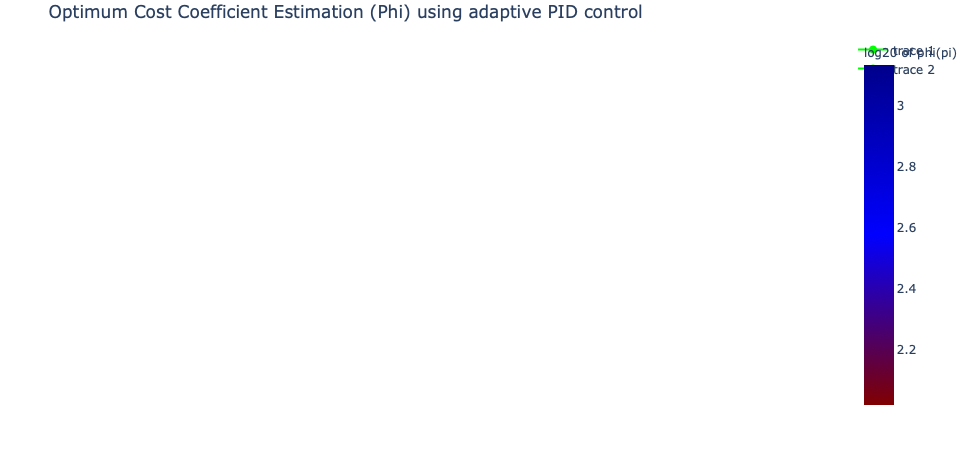

In [151]:
fig = px.scatter_3d(global_phi_store_q, 
                                x = global_phi_store_q["kp"],
                                y = global_phi_store_q["ki"],
                                z = global_phi_store_q["kd"],
                                title = 'Optimum Cost Coefficient Estimation (Phi) using adaptive PID control',
                                color = global_phi_store_q["log20 of phi(pi)"], #4th dimension is colour 
                                color_continuous_scale = ['maroon', 'blue', 'darkblue'], # Determines the color scale used
                                size_max = 1,
                                opacity = 1)

fig.update_layout(margin=dict(l=35, r=35, b=35, t=35))


# Add the trace of the OPTIMUM POINT manually here using a green dot
data1 = {'kp':[5], 
        'ki':[5],
        'kd':[0],
        'log20 of phi(pi)': [1.698002]}

data2 = {'kp':[5], 
        'ki':[0],
        'kd':[0],
        'log20 of phi(pi)': [1.698002]}
# Create the pandas DataFrame 
df1 = pd.DataFrame(data1, columns = ['kp', 'ki', 'kd', 'log20 of phi(pi)']) 
fig.add_traces(go.Scatter3d(x = df1['kp'],
                                    y = df1['ki'],
                                    z = df1['kd'],
                                    marker = dict(
                                    color = 'lime'),
                                    text = ['Phi Approximate Optimum 1']
                               )
                 )

# Mark the other optimum where it converges to -- seems to me that th controller thinks kp is enough. 
df2 = pd.DataFrame(data2, columns = ['kp', 'ki', 'kd', 'log20 of phi(pi)']) 
fig.add_traces(go.Scatter3d(x = df2['kp'],
                                    y = df2['ki'],
                                    z = df2['kd'],
                                    marker = dict(
                                    color = 'lime'),
                                    text = ['Phi Approximate Optimum 2']
                               )
                 )
fig.show()

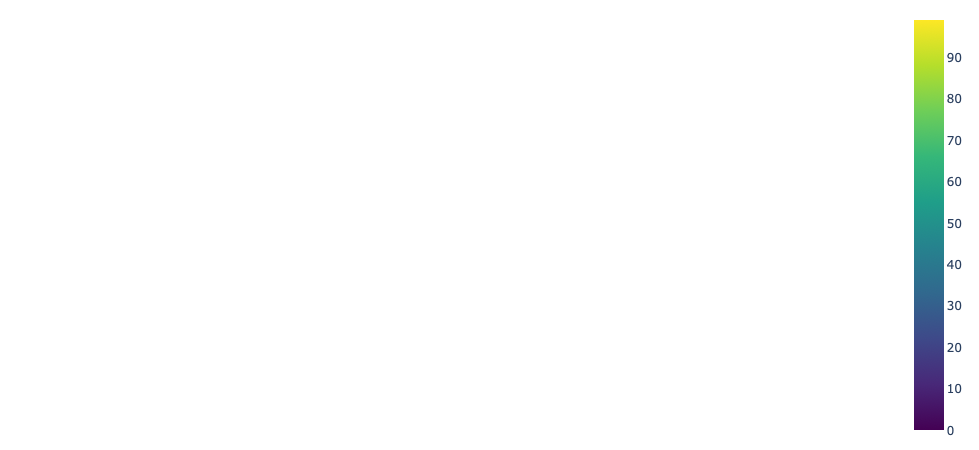

In [92]:
#go family is superseded by the express class which I am using now. 

fig = go.Figure(data =[go.Scatter3d(x=global_phi_store_q["kp"],
                                    y = global_phi_store_q["ki"],
                                    z = global_phi_store_q["kd"],
                                    connectgaps = True,
                                    
                                    marker = dict(color=global_phi_store_q["phi(pi) n-tiles"],
                                                  colorscale="viridis", showscale=True
                                                 )
                                    )])
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.update_layout(scene = dict(
                    xaxis_title='Kp',
                    yaxis_title='Ki',
                    zaxis_title='Kd'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [452]:
# Run this again but for a model that only optimises kp and ki
u = np.linspace(0, 1, 20)
v = np.linspace(0, 1, 20)
u,v = np.meshgrid(u,v)
u = u.flatten()
v = v.flatten()

points2D = np.vstack([u,v]).T
tri = Delaunay(points2D)
simplices = tri.simplices

fig = ff.create_trisurf(x=global_phi_store_q['kp'], y=global_phi_store_q['ki'], z=global_phi_store_q['phi(pi)'],
                         colormap="Portland",
                         simplices=simplices,
                         title="kp ki surface plot - lol ignore this pls. I was drunk")
fig.show()

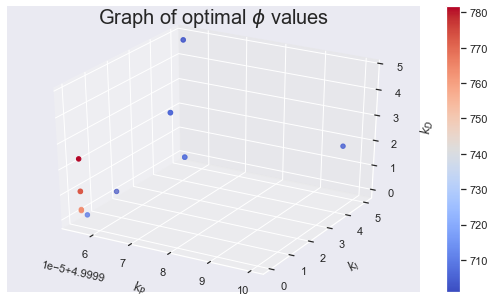

In [98]:
fig = plt.figure()
fig.set_size_inches(18.5/2, 10.5/2)
ax = fig.add_subplot(111, projection='3d')

plt.title('Graph of optimal $\phi$ values', fontsize=20)
ax.set_xlabel('$k_P$', fontsize=12, labelpad=10)
ax.set_ylabel('$k_I$', fontsize=12, labelpad=10)
ax.set_zlabel('$k_D$', fontsize=12, labelpad=10)

x = array_opt_pi[:,0]
y = array_opt_pi[:,1]
z = array_opt_pi[:,2] 
c = phi_for_opt_store

img = ax.scatter(x, y, z, c=c, cmap=cm.coolwarm, depthshade=True)
fig.colorbar(img)
plt.show()

### Improvements which can be made to the efficiency of the code

We can instead of writing two for loops simply integrate system as we were doing before using the t_eval argument for the scipy integrator and instead subtract each neighbouring integral i.e. the integral at (t+2) - integral at (t+1) etc. This would give us the required x array of states of the system at any given time and therefore allow us to be more efficient computationally. 

I have now added a disturbance and noise terms to the system output and the controller response, resectively.

The reason the controller response keeps getting larger is because there is a steady-state error which means the integrals term of the controller keeps getting larger, increasing the response of the controller with each second in an attempt to correct the error. 

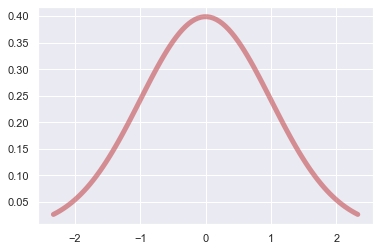

In [315]:
fig, ax = plt.subplots(1, 1)
mean, var, skew, kurt = norm.stats(moments='mvsk')
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)

ax.plot(x, norm.pdf(x), 
        'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()

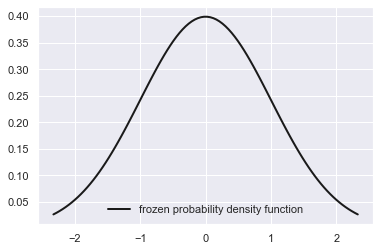

In [316]:
rv = norm()
fig, ax = plt.subplots(1, 1)
ax.plot(x,rv.pdf(x), 'k-', lw=2, label='frozen probability density function')
ax.legend(loc='best', frameon=False)
plt.show()

Can add a small discussion about the probability density function and normal distribution used to add the stochastic element to this equation. 